In [1]:
import numpy as np

train_images = np.load('quickdraw_subset_np/train_images.npy')
train_labels = np.load('quickdraw_subset_np/train_labels.npy')
test_images = np.load('quickdraw_subset_np/test_images.npy')
test_labels = np.load('quickdraw_subset_np/test_labels.npy')

print(train_images.shape) # (20000, 28, 28)
print(test_images.shape) # (5000, 28, 28)
print(train_images[0].shape) # 28 x 28
print(train_labels) 

(20000, 28, 28)
(5000, 28, 28)
(28, 28)
[1 3 3 ... 2 3 2]


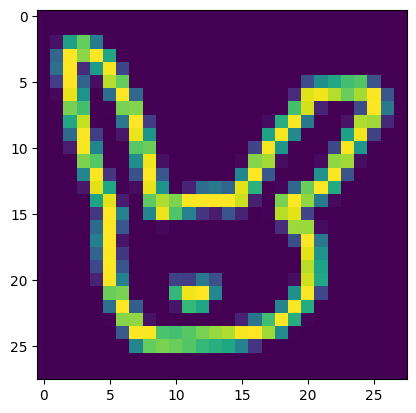

In [10]:
import matplotlib.pyplot as plt

plt.imshow(train_images[1234])


In [2]:
##Feature Extraction

train_flat = train_images.reshape(train_images.shape[0], -1)
test_flat = test_images.reshape(test_images.shape[0], -1)

# PCA
#https://medium.com/technological-singularity/build-a-principal-component-analysis-pca-algorithm-from-scratch-7515595bf08b


def PCA_from_Scratch(X, n_components):
    X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-4)
    cov_mat = np.cov(X, rowvar=False)
    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)  # Use eigh for symmetric matrices (covariance is symmetric)
    sort_indices = np.argsort(eigen_values)[::-1]
    principal_components = eigen_vectors[:, sort_indices[:n_components]]

    return principal_components


def transform(X, principal_components):
    X = X.copy()
    return X.dot(principal_components)



# LDA 
#https://www.kaggle.com/code/egazakharenko/linear-discriminant-analysis-lda-from-scratch
class LDA():
  def __init__(self, n_components=None):
     self.n_components = n_components
  def fit(self,X,y):
     self.X = X
     self.y = y
     samples = X.shape[0]
     features= X.shape[1]
     classes, cls_counts = np.unique(y,return_counts=True)
     priors = cls_counts/samples
     X_mean = np.array([X[y==cls].mean(axis=0) for cls in classes])
     betweenCLSdeviation = X_mean - X.mean(axis=0)
     withinCLSdeviation = X - X_mean[y]

     Sb = priors* betweenCLSdeviation.T @ betweenCLSdeviation
     Sw = withinCLSdeviation.T @ withinCLSdeviation / samples
     Sw_inv = np.linalg.pinv(Sw)
     eigvals, eigvecs = np.linalg.eig(Sw_inv @ Sb)
     self.dvecs = eigvecs[:, np.argsort(eigvals)[::-1]]
     self.weights = X_mean @ self.dvecs @ self.dvecs.T
     self.bias = np.log(priors) - 0.5 * np.diag(X_mean @ self.weights.T)
     if self.n_components is None:
        self.n_components = min(classes.size - 1, features)
  def transform(self, X):
    return X @ self.dvecs[:, : self.n_components]

  def predict(self, X_test):
    scores = X_test @ self.weights.T + self.bias
    return np.argmax(scores, axis=1)
  
def macroF1(y_pred, y_true):
    labels = np.unique(y_true)
    f1_scores = []

    for label in labels:
        tp = np.sum((y_pred == label) & (y_true == label))
        fp = np.sum((y_pred == label) & (y_true != label))
        fn = np.sum((y_pred != label) & (y_true == label))

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        f1_scores.append(f1)

In [3]:
pcs = PCA_from_Scratch(train_flat, 2)
train_proj = transform(train_flat, pcs)
train_proj.shape


(20000, 2)

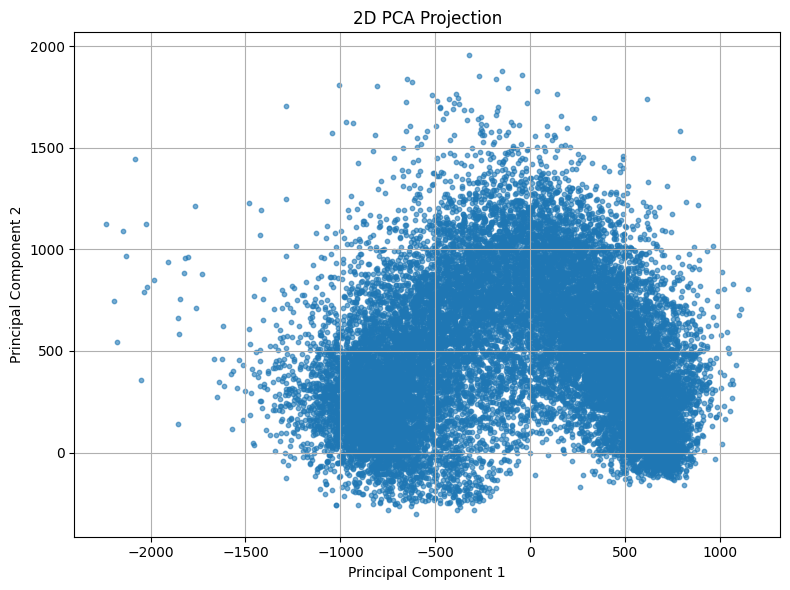

In [13]:
labels = np.unique(train_labels)
def plot_2d_projection(data, labels=None, title="2D PCA Projection"):
    plt.figure(figsize=(8, 6))
    if labels is not None:
        scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', s=10, alpha=0.6)
        plt.legend(*scatter.legend_elements(), title="Classes")
    else:
        plt.scatter(data[:, 0], data[:, 1], s=10, alpha=0.6)

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_2d_projection(train_proj)


In [6]:
train_normal = train_flat/255
test_normal = test_flat/255
train_normal.shape
lda = LDA()
lda.fit(train_normal,train_labels)
lda_train = lda.transform(train_normal)
lda_test = lda.transform(test_normal)

In [8]:
class myKNearesNeighbour():
    def __init__(self, k):
        self.k = k
    def fit(self, X_train,y_train):
        self.X_train = X_train
        self.y_train = y_train
    def predict(self, X_test):
        self.X_test = X_test
        y_pred = np.zeros(self.X_test.shape[0])
        for i, image in enumerate(X_test):
            neighbours = self.findNeighbours(image)
            y_pred[i] = self.mode(neighbours)
        return y_pred
    def findNeighbours(self, image):
        sortedList = np.argsort(self.Euclidean(image)) 
        y_train_sorted = self.y_train[sortedList]
        return y_train_sorted[:self.k]
    def mode(self, vector):
        values, counts = np.unique(vector, return_counts=True)
        return values[np.argmax(counts)]
    def Euclidean(self,image):
        distances = np.sqrt(np.sum((self.X_train - image) ** 2, axis=1))
        return distances
    
        

def score(y_pred, y_true):
        accuracy = np.mean(y_pred == y_true)
        return accuracy


In [ ]:
train_normal = train_flat/255
test_normal = test_flat/255

n_neighbours = [3,5,7,9]
scores = []
macrolist = []
for k in n_neighbours:
    KNN = myKNearesNeighbour(k)
    KNN.fit(lda_train,train_labels)
    y_pred = KNN.predict(lda_test)
    result = score(y_pred, test_labels)
    scores.append(result)
    macrolist.append(macroF1(y_pred,test_labels))
    print(k , " N neighbours with LDA ", result)

for k in n_neighbours:
    KNN = myKNearesNeighbour(k)
    KNN.fit(train_normal,train_labels)
    y_pred = KNN.predict(test_normal)
    result = score(y_pred, test_labels)
    scores.append(result)
    macrolist.append(macroF1(y_pred,test_labels))
    print(k , " N neighbours only with normalized " , result)

componentAmount = [16, 32, 64, 128, 256]
principal_comps = []
train_transform = []
test_transform = []
y_pred = []
scorePCA = []
for k in n_neighbours:
    for number in componentAmount:
        pcs = PCA_from_Scratch(train_flat, number)
        principal_comps.append(pcs)
        
        train_proj = transform(train_flat, pcs)
        test_proj = transform(test_flat, pcs)
        train_transform.append(train_proj)
        test_transform.append(test_proj)
        
        KNN_PCA = myKNearesNeighbour(k)
        KNN_PCA.fit(train_proj, train_labels)
        pred = KNN_PCA.predict(test_proj)
        y_pred.append(pred)
        macroscore = macroF1(y_pred,test_labels)
        normalscore = score(pred, test_labels)

        print(k, " with PCA component number: ", number, "and scores are: Macro : ", macroscore,"Accuracy ", normalscore)


3  N neighbours with LDA  0.7192
5  N neighbours with LDA  0.734
7  N neighbours with LDA  0.7424
9  N neighbours with LDA  0.7474
3  N neighbours only with normalized  0.836
5  N neighbours only with normalized  0.84
7  N neighbours only with normalized  0.8468
9  N neighbours only with normalized  0.8414
3  with PCA component number:  16 and scores are: Macro :  None Accuracy  0.8134
3  with PCA component number:  32 and scores are: Macro :  None Accuracy  0.8412
3  with PCA component number:  64 and scores are: Macro :  None Accuracy  0.8518
3  with PCA component number:  128 and scores are: Macro :  None Accuracy  0.856
3  with PCA component number:  256 and scores are: Macro :  None Accuracy  0.8448
5  with PCA component number:  16 and scores are: Macro :  None Accuracy  0.8236
5  with PCA component number:  32 and scores are: Macro :  None Accuracy  0.8532
5  with PCA component number:  64 and scores are: Macro :  None Accuracy  0.8548
5  with PCA component number:  128 and scor

In [38]:
componentAmount = [16, 32, 64, 128, 256]
principal_comps = []
train_transform = []
test_transform = []
y_pred = []
scorePCA = []

for number in componentAmount:
    pcs = PCA_from_Scratch(train_flat, number)
    principal_comps.append(pcs)
    
    train_proj = transform(train_flat, pcs)
    test_proj = transform(test_flat, pcs)
    train_transform.append(train_proj)
    test_transform.append(test_proj)
    
    KNN_PCA = myKNearesNeighbour(3)
    KNN_PCA.fit(train_proj, train_labels)
    pred = KNN_PCA.predict(test_proj)
    y_pred.append(pred)
    
    scorePCA.append(score(pred, test_labels))
    print("One is done")


One is done
One is done
One is done
One is done
One is done


In [4]:
class myNaiveBayes():
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}
    def fit(self,X_train,y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.classes = np.unique(y_train)
        for w in self.classes:
            X_train_w = X_train[y_train == w]
            P_w = X_train_w.shape[0] / X_train.shape[0] # Prior Densities P(w_j)
            self.priors[w] = P_w
            self.likelihoods[w] = {}
            for x in range(X_train.shape[1]):
                feature_x = X_train_w[:,x]
                mean_x_w = np.mean(feature_x)
                var_x_w = np.var(feature_x)
                self.likelihoods[w][x] = (mean_x_w, var_x_w)

    def gaussianDensity(self,x,mean,var):
        denu = 1.0 / np.sqrt(2.0 * np.pi * (var + 1e-4))
        inexp = -((x - mean) ** 2) / (2 * (var + 1e-4))
        return denu*np.exp(inexp)
    
    def predict(self, X_test):
        y_pred = []
        for x in X_test:
            posteriors = {}
            for c in self.classes:
                log_prior = np.log(self.priors[c])
                log_likelihood = 0
                for i in range(len(x)):
                    mean, var = self.likelihoods[c][i]
                    log_likelihood += np.log(self.gaussianDensity(x[i], mean, var) + 1e-10)
                posteriors[c] = log_prior+log_likelihood
            y_pred.append(max(posteriors, key=posteriors.get))
        return y_pred

In [10]:
mybayes = myNaiveBayes()
mybayes.fit(train_normal,train_labels)
y_pred = mybayes.predict(test_normal)
acc = score(y_pred,test_labels)
mac = macroF1(y_pred,test_labels)
print("Naive Bayes with Just Normalization: accuracy: ", acc, "Macroscore: ", mac)

mybayes = myNaiveBayes()
mybayes.fit(lda_train,train_labels)
y_pred = mybayes.predict(lda_test)
acc = score(y_pred,test_labels)
mac = macroF1(y_pred,test_labels)
print("Naive Bayes with LDA Transformation: accuracy: ", acc, "Macroscore: ", mac)

componentAmount = [16, 32, 64, 128, 256]
principal_comps = []
train_transform = []
test_transform = []
y_pred = []
scorePCA = []
for number in componentAmount:
    pcs = PCA_from_Scratch(train_normal, number)
    principal_comps.append(pcs)
        
    train_proj = transform(train_normal, pcs)
    test_proj = transform(test_normal, pcs)

    mybayes = myNaiveBayes()
    mybayes.fit(train_proj,train_labels)
    y_pred1 = mybayes.predict(test_proj)
    macroscore = macroF1(y_pred1, test_labels)
    normalscore = score(y_pred1, test_labels)

    print( "Naive Bayes with PCA component number: ", number, "and scores are: Macro : ", macroscore,"Accuracy ", normalscore)

Naive Bayes with Just Normalization: accuracy:  0.573 Macroscore:  None
Naive Bayes with LDA Transformation: accuracy:  0.7416 Macroscore:  None
Naive Bayes with PCA component number:  16 and scores are: Macro :  None Accuracy  0.7312
Naive Bayes with PCA component number:  32 and scores are: Macro :  None Accuracy  0.7384
Naive Bayes with PCA component number:  64 and scores are: Macro :  None Accuracy  0.7432
Naive Bayes with PCA component number:  128 and scores are: Macro :  None Accuracy  0.7416
Naive Bayes with PCA component number:  256 and scores are: Macro :  None Accuracy  0.7228


In [13]:
class myMultiClassLogisticRegression():
    def __init__(self, learning_rate=0.1, maxiterations=10000, mu=0.0):
        
        self.learning_rate = learning_rate
        self.maxiterations = maxiterations
        self.mu = mu  # regularization strength
        self.W = None  # weight matrix

    def OneHotEncoder(self, y_train, num_classes):

        y_trainNew = np.zeros((y_train.shape[0], num_classes))
        for i, label in enumerate(y_train):
            y_trainNew[i, label] = 1
        return y_trainNew

    def softmax(self, Z):
        
        Z_shifted = Z - np.max(Z, axis=1, keepdims=True)  # stability
        exp_Z = np.exp(Z_shifted)
        return np.real(exp_Z / np.sum(exp_Z, axis=1, keepdims=True))

    def loss(self, X, Y, W):
        
        N = X.shape[0]
        logits = X @ W  # shape (N, C)
        P = self.softmax(logits)  # shape (N, C)
        eps = 1e-15
        cross_entropy = -np.mean(np.sum(Y * np.log(P + eps), axis=1))
        reg_term = self.mu * np.sum(W**2)
        return cross_entropy + reg_term

    def gradient(self, X, Y, W):
        
        N = X.shape[0]
        logits = X @ W  # shape (N, C)
        P = self.softmax(logits)  # shape (N, C)
        grad = (1.0 / N) * (X.T @ (P - Y)) + 2.0 * self.mu * W
        return np.real(grad)

    def fit(self, X_train, y_train):
       
        self.n_images, self.n_features = X_train.shape
        num_classes = len(np.unique(y_train))
        Y_onehot = self.OneHotEncoder(y_train, num_classes)
        self.W = np.zeros((self.n_features, num_classes))
        for _ in range(self.maxiterations):
            grad = self.gradient(X_train, Y_onehot, self.W)
            self.W -= self.learning_rate * grad

    def predict(self, X_test):
       
        logits = X_test @ self.W  
        P = self.softmax(logits)  
        return np.argmax(P, axis=1)

        

In [15]:
myLog = myMultiClassLogisticRegression()
myLog.fit(train_normal,train_labels)
y_pred = myLog.predict(test_normal)
score(y_pred,test_labels)

0.7508

In [12]:

class OneVsAllLogisticRegression:
    def __init__(self, learning_rate=0.1, max_iter=1000, _lambda=0.1):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self._lambda = _lambda
        self.classifiers = None
        self.classes_ = None

    def sigmoid(self, z):
        return np.real(1.0 / (1 + np.exp(-z)))

    def cost_fun(self, W, X, y):
        N  = X.shape[0]
        h = self.sigmoid(X @ W)
        eps = 1e-15
        cost = -(1.0/N) * (y.T @ np.log(h + eps) + (1 - y).T @ np.log(1 - h + eps)) + (self._lambda / (2*N)) * np.sum(W**2)
        return cost

    def gradient(self, W, X, y):
        N = X.shape[0]
        h = self.sigmoid(X @ W)
        grad = (1.0/N) * X.T @ (h - y) + (self._lambda/N) * W
        return np.real(grad)

    def fit(self, X, y):
        m, n = X.shape
        self.classes_ = np.unique(y)
        k = len(self.classes_)
        all_theta = np.zeros((k, n))
        for i, cls in enumerate(self.classes_):
            binary_y = (y == cls).astype(float)
            theta = np.zeros(n)
            for _ in range(self.max_iter):
                theta -= self.learning_rate * self.gradient(theta, X, binary_y)
            all_theta[i] = theta
        self.classifiers = all_theta

    def predict(self, X):
        probs = self.sigmoid(X.dot(self.classifiers.T))
        predictions = np.array([self.classes_[np.argmax(probs[i])] for i in range(X.shape[0])])
        return predictions


In [ ]:
learning_rates = [0.01, 0.1, 0.5]
lambas = [0, 0.01, 0.1, 1]
results = []
accuracy = []

def macroF1(y_pred, y_true):
    labels = np.unique(y_true)
    f1_scores = []

    for label in labels:
        tp = np.sum((y_pred == label) & (y_true == label))
        fp = np.sum((y_pred == label) & (y_true != label))
        fn = np.sum((y_pred != label) & (y_true == label))

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        f1_scores.append(f1)

PCAs = []
componentAmount = [256]
for number in componentAmount:
    pcs = PCA_from_Scratch(train_normal, number)
    principal_comps.append(pcs)
    train_proj = transform(train_normal, pcs)
    test_proj = transform(test_normal, pcs)
    PCAs.append([train_proj, test_proj, number])

for dataset in PCAs:
    for lr in learning_rates:
        for lamb in lambas:
            
            
            modelMC = myMultiClassLogisticRegression(learning_rate=lr, maxiterations=1000, mu=lamb)
            modelMC.fit(dataset[0], train_labels)
            y_pred3 = modelMC.predict(dataset[1])
            accuracy = score(y_pred=y_pred3,y_true=test_labels)
            macro = macroF1(y_pred=y_pred3,y_true=test_labels)            
            print("With PCA Amount:", dataset[2] ,"MultiClass Learning Rate:", lr, "Lambda:", lamb, "Test Accuracy:", accuracy)
        
        modelOA = OneVsAllLogisticRegression(learning_rate=lr, max_iter=1000, _lambda=0.1)
        modelOA.fit(dataset[0], train_labels)
        y_pred2 = modelOA.predict(dataset[1])
        accuracy = score(y_pred=y_pred2,y_true=test_labels)
        macro = macroF1(y_pred=y_pred2,y_true=test_labels)            
        print("With PCA Amount:", dataset[2] ,"One vs All Learning Rate:", lr, "Lambda:", 0.1, "Test Accuracy:", accuracy)

With PCA Amount: 256 MultiClass Learning Rate: 0.01 Lambda: 0 Test Accuracy: 0.7318
With PCA Amount: 256 MultiClass Learning Rate: 0.01 Lambda: 0.01 Test Accuracy: 0.7302
With PCA Amount: 256 MultiClass Learning Rate: 0.01 Lambda: 0.1 Test Accuracy: 0.7176
With PCA Amount: 256 MultiClass Learning Rate: 0.01 Lambda: 1 Test Accuracy: 0.6762
With PCA Amount: 256 One vs All Learning Rate: 0.01 Lambda: 0.1 Test Accuracy: 0.724
With PCA Amount: 256 MultiClass Learning Rate: 0.1 Lambda: 0 Test Accuracy: 0.7516
With PCA Amount: 256 MultiClass Learning Rate: 0.1 Lambda: 0.01 Test Accuracy: 0.7448
With PCA Amount: 256 MultiClass Learning Rate: 0.1 Lambda: 0.1 Test Accuracy: 0.7194
With PCA Amount: 256 MultiClass Learning Rate: 0.1 Lambda: 1 Test Accuracy: 0.6762
With PCA Amount: 256 One vs All Learning Rate: 0.1 Lambda: 0.1 Test Accuracy: 0.7476
With PCA Amount: 256 MultiClass Learning Rate: 0.5 Lambda: 0 Test Accuracy: 0.7276
With PCA Amount: 256 MultiClass Learning Rate: 0.5 Lambda: 0.01 Test 